In [1]:

import sys
import os
sys.path.append('../')

from mbt_gym.agents.BaselineAgents import RandomAgent, FixedSpreadAgent, AvellanedaStoikovAgent, CarteaJaimungalMmAgent
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest
from hftbacktest.data.utils import tardis
from hftbacktest import Recorder

from utils import *


In [2]:

base_path = os.path.join(os.path.dirname("__file__"))
trades_file = os.path.join(base_path, "data/BTCUSDT_trades.csv.gz")
book_file = os.path.join(base_path, "data/BTCUSDT_book.csv.gz")

# fees are around 0.10% for binance
maker_fee = 0.0001 # 0.01%
taker_fee = 0.0001 # 0.01%
entry_lantency = 10_000_000 # 10ms
response_latency = 10_000_000 # 10ms
tick_size = 0.1 # order price precision
lot_size = 0.001 # minimum asset qty we can exchange

data = tardis.convert(
    [trades_file, book_file]
    )

asset = (
    BacktestAsset()
        .data([data])
        .linear_asset(1.0)
        .constant_latency(entry_lantency, response_latency) # 10ms
        .risk_adverse_queue_model()
        .no_partial_fill_exchange()
        .trading_value_fee_model(maker_fee, taker_fee)
        .tick_size(tick_size)
        .lot_size(lot_size)
        .last_trades_capacity(0)
)


Reading data/BTCUSDT_trades.csv.gz
Reading data/BTCUSDT_book.csv.gz
Correcting the latency
Correcting the event order


The `asset` variable is a data structure that contains the order book every 100ms and all the trades.

The `hbt` variable is an object of type `HashMapMarketDepthBacktest` that allows resimulating the evolution of trades within the `asset`.

### Simulation Mechanics

- `hbt.elapse(dt)` advances the simulation by `dt` nanoseconds.
- Orders can be placed using:
  ```python
  hbt.submit_buy_order(asset_no, order_id, price, lot_order_qty, GTX, LIMIT, False)
- The simulation is then advanced again to check if the order has been executed.

### Model Components
We use the following models:

- `constant_latency()`
- `risk_adverse_queue_model()`
- `no_partial_fill_exchange()`
- `trading_value_fee_model()`


### Execution Rules for Limit Orders

#### Bid Limit Order Execution
A bid limit order is executed if one of these three conditions is met:

1. The bid limit order price is higher than the best ask limit order price.
2. The bid limit order price is higher than the best bid, and there is an incoming market sell order.
3. The bid limit order price is equal to the best bid, is at the front of the queue, and there is an incoming market sell order.

#### Ask Limit Order Execution
An ask limit order is executed if one of these three conditions is met:

1. The ask limit order price is lower than the best bid limit order price.
2. The ask limit order price is lower than the best ask, and there is an incoming market buy order.
3. The ask limit order price is equal to the best ask, is at the front of the queue, and there is an incoming market buy order.


### Execution Model Assumptions
- With `no_partial_fill_exchange()`, an order is fully executed or not executed at all. (For small trading quantities, this model is realistic.)
- The `risk_adverse_queue_model()` provides a conservative queue position model, where your order’s position in the queue advances only when trades occur at the same price level.


In [3]:
hbt = HashMapMarketDepthBacktest([asset])

# The timestamps are in nanoseconds
# we skip the first 2 seconds
hbt.elapse(1_000_000_000 * 2)

asset_no = 0
init_time = hbt.current_timestamp
final_time = 1_000_000_000

while hbt.elapse(1_000_000_000 * 0.1) == 0:

    depth = hbt.depth(asset_no)
    current_time = hbt.current_timestamp - init_time
    mid_price = (depth.best_bid + depth.best_ask) / 2.0
    print(f"time : {current_time/1_000_000_000}s, midprice : {mid_price:.2f}")

    if current_time == final_time:
        break

_ = hbt.close()

time : 0.1s, midprice : 9365.80
time : 0.2s, midprice : 9366.00
time : 0.3s, midprice : 9366.00
time : 0.4s, midprice : 9366.00
time : 0.5s, midprice : 9366.00
time : 0.6s, midprice : 9366.15
time : 0.7s, midprice : 9366.15
time : 0.8s, midprice : 9366.30
time : 0.9s, midprice : 9366.30
time : 1.0s, midprice : 9366.55


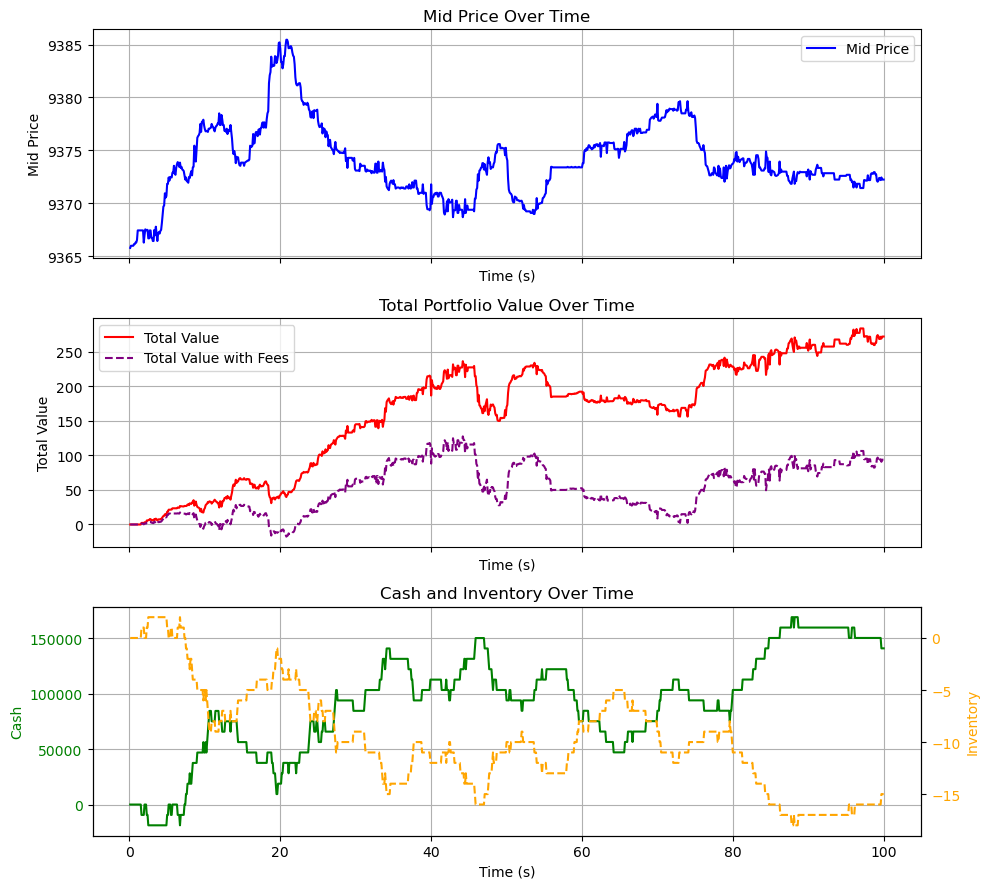

In [5]:

from mbt_gym_backtest import * 

terminal_time = 100 # in seconds
step_size = 0.1
n_steps = int(terminal_time / step_size)
seed = 42
order_qty = 10 # in lot_size
np.random.seed(seed)

# Arrival and fill models parameters
intensity = np.array([140, 140])
fill_exponent = 1.5

n_prices = int(terminal_time/step_size)
hbt = HashMapMarketDepthBacktest([asset])
historical_prices = get_midprices(hbt, dt=step_size, size=n_prices)
hbt.close()

midprice_model = HistoricalMidpriceModel(midprice_list=historical_prices, step_size=step_size, seed=seed)
arrival_model = PoissonArrivalModel(intensity=intensity, step_size=step_size, seed=seed)
fill_probability_model = ExponentialFillFunction(fill_exponent, step_size=step_size, seed=seed)
model_dynamics = BackTestingLimitOrderModelDynamics(midprice_model=midprice_model, arrival_model=arrival_model, fill_probability_model=fill_probability_model)

env = BackTestingTradingEnvironment(terminal_time=terminal_time, n_steps=n_steps, seed=seed, model_dynamics=model_dynamics)
agent = RandomAgent(env, seed=seed)

def limit_order_model_back_testing(hbt, env, agent, step_size, order_qty, recorder):
    """
    """

    ask_executed, bid_executed, asset_no = 0, 0, 0

    # balance and num_trades variables are use to determine if the order is executed
    trading_balance = hbt.state_values(asset_no).balance
    num_trades = hbt.state_values(asset_no).num_trades

    tick_size = hbt.depth(asset_no).tick_size
    lot_size = hbt.depth(asset_no).lot_size
    obs, real_obs = env.reset()

    hbt.elapse(1_000_000_000 * 2) # Skip the two first second

    # Placing orders
    action = agent.get_action(obs)
    order_qty = 1000 # the current mbt-gym env only allow to buy 1 qty of the asset (1000 correspond to 1/lot_size)
    bid_order_id, ask_order_id = place_orders(hbt, action, asset_no, lot_size, tick_size, order_qty)

    while hbt.elapse(1_000_000_000 * step_size) == 0:

        hbt.clear_inactive_orders(asset_no)

        # get the executed status of the previous orders
        bid_executed, ask_executed = get_executed_status(hbt, bid_order_id, ask_order_id, asset_no, trading_balance, num_trades)
        trading_balance = hbt.state_values(asset_no).balance
        num_trades = hbt.state_values(asset_no).num_trades

        obs, real_obs, _, done, _ = env.step(action, np.array([[bid_executed, ask_executed]]))
        
        recorder.record(real_obs, hbt)

        if (env.num_trajectories > 1 and done[0]) or (env.num_trajectories == 1 and done):
            break
        
        # Placing new orders
        action = agent.get_action(obs)
        bid_order_id, ask_order_id = place_orders(hbt, action, asset_no, lot_size, tick_size, order_qty)

    return True


recorder = Recorder(step_size, n_steps, order_qty)

hbt = HashMapMarketDepthBacktest([asset])

limit_order_model_back_testing(hbt, env, agent, step_size, order_qty, recorder)

_ = hbt.close()

recorder.plot()




### remarks

It is complex to determine whether an order has been executed. There are native functions that plot the evolution of the trading strategy and have access to the execution status, but since they use Rust, it is difficult to access them freely. The function I built, **get_executed_status(hbt, bid_order_id, ask_order_id, asset_no, trading_balance, num_trades)**, uses the evolution of the balance and the number of trades to rebuild the execution status. It might only work for the current case.